In [1]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from urllib.parse import urlparse
import matplotlib.pyplot as plt
from sklearn import tree
import sklearn



In [4]:
breast_cancer = load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target

In [5]:
df_feat=pd.DataFrame(X,columns=breast_cancer['feature_names'])
df_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [6]:
df_target=pd.DataFrame(y,columns=['cancer'])
display(df_target)

,cancer
0,0
1,0
2,0
3,0
4,0
...,...
564,0
565,0
566,0
567,0


In [7]:
#now standarizing the model
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

#Fit the model
scaler.fit(df_feat)

#Transform the dataset
scaled_features=scaler.transform(df_feat)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
     scaled_features, np.ravel(df_target), test_size=0.30, random_state=105)
kfold = KFold(n_splits=3, shuffle=True)

In [8]:
def parameter_tuning(k_folds,trainx,trainy):
    parameters = {'criterion': ['gini','entropy'], 'splitter': ['best','random'], 'max_depth': [2,3,4]}
    clf = DecisionTreeClassifier()
    grid = GridSearchCV(clf, parameters, cv = k_folds)
    grid.fit(trainx,trainy)

    best_max_depth = grid.best_params_['max_depth']
    best_splitter = grid.best_params_['splitter']
    best_criterion = grid.best_params_['criterion']

    return best_max_depth, best_splitter, best_criterion

def k_fold_cv(depth, splitterm, criterion, trainx, trainy,kfold):
    clf = DecisionTreeClassifier(max_depth=depth,splitter=splitterm,criterion=criterion)

    k_fold_scores = cross_val_score(clf, trainx,trainy,cv=kfold)
    return k_fold_scores, clf

def train_model(clf,trainx, trainy, testx, testy):
    clf.fit(trainx, trainy)
    train_accuracy = clf.score(trainx, trainy)
    test_accuracy = clf.score(testx,testy)
    pred = clf.predict(testx)
    return train_accuracy, test_accuracy, pred

def create_confusion_matrix_plot(clf, X_test, y_test):
    from sklearn.metrics import plot_confusion_matrix
    plot_confusion_matrix(clf, X_test, y_test)
    plt.savefig('confusion_matrix.png')

def save_image(clf):
    fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
    tree.plot_tree(clf)
    fig.savefig("image.png")
    
    
    



2023/06/09 16:56:36 INFO mlflow.tracking.fluent: Experiment with name 'Decision Tree Classifier Experiment 4' does not exist. Creating a new experiment.
/Users/enazec/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/enazec/opt/anaconda3/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'cancer_model'.
2023/06/09 16:56:40 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: cancer_model, version 1


Error occured: %s Path 'cancer_model' already exists and is not empty


Created version '1' of model 'cancer_model'.


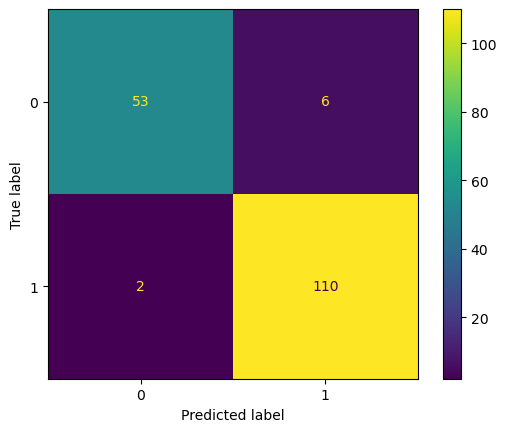

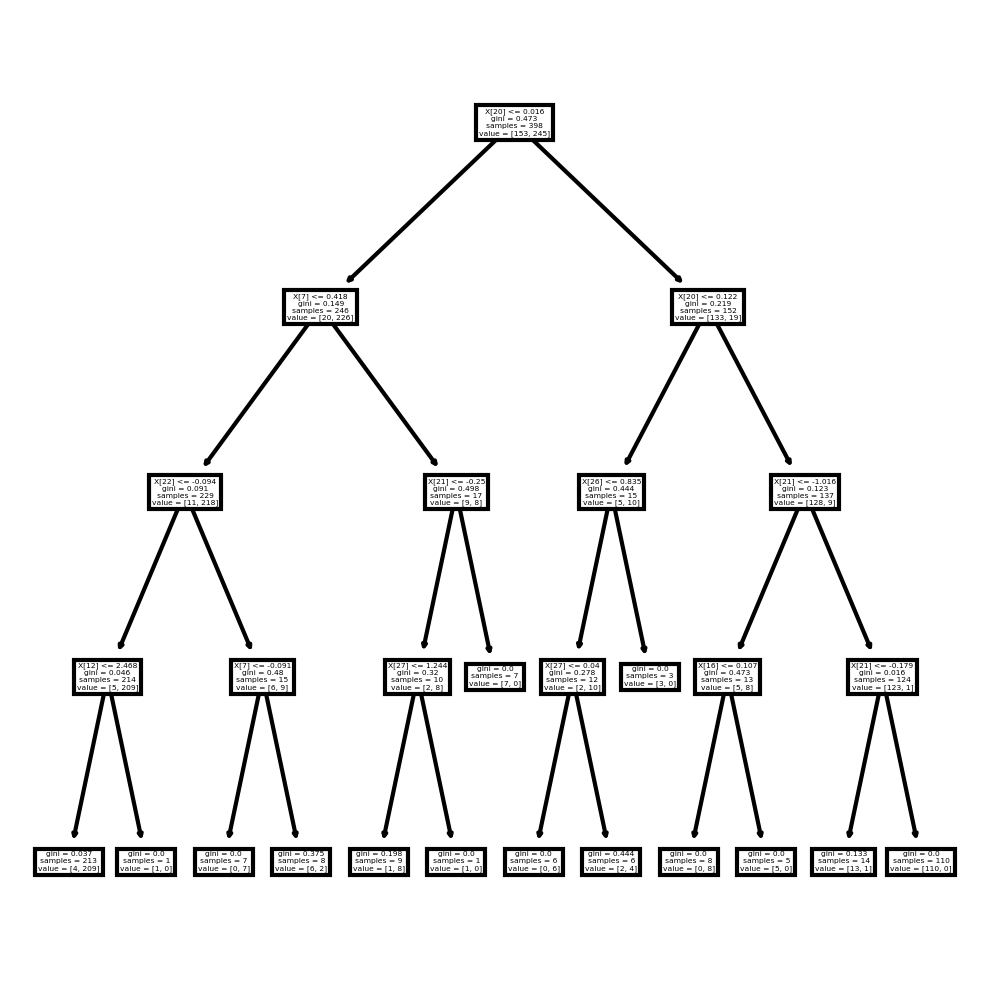

In [14]:
experiment_name = "Decision Tree Classifier Experiment 4" 
mlflow.set_tracking_uri('http://127.0.0.1:5001')
mlflow.set_experiment(experiment_name)
with mlflow.start_run(run_name='New model'):
    best_max_depth, best_splitter, best_criterion = parameter_tuning(kfold,X_train,y_train)
    mlflow.log_param(f'best_max_depth', best_max_depth)
    mlflow.log_param(f'best_criterion', best_criterion)
    mlflow.log_param(f'best_splitter', best_splitter)

    k_fold_scores, clf = k_fold_cv(best_max_depth, best_splitter, best_criterion, X_train, y_train, kfold)
    mlflow.log_metric(f"average_accuracy", k_fold_scores.mean())
    mlflow.log_metric(f"std_accuracy", k_fold_scores.std())

    train_accuracy, test_accuracy, pred = train_model(clf, X_train, y_train,X_test,y_test)
    mlflow.log_metric(f"train_accuracy",train_accuracy )
    mlflow.log_metric(f"test_accuracy", test_accuracy)  

    mlflow.set_tag("First Tag","Decision Tree Classifier")
    mlflow.set_tags({"Testing Tag":"Model working properly","Update Tag":"Hyperparameter Tuning","Model Status":"Model Uplaoded","Decision Tree Status":"Model Image Uploaded"})
    
    create_confusion_matrix_plot(clf,X_test,y_test)
    save_image(clf)

    mlflow.log_artifact("image.png")
    mlflow.log_artifact("confusion_matrix.png")

    predictions = clf.predict(X_train)
    signature = infer_signature(X_train,predictions)
    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

    if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(clf,'model',registered_model_name='cancer_model',signature=signature)
    else:
        mlflow.sklearn.log_model(clf,'model',signature=signature)
    
    try:
        mlflow.sklearn.save_model(clf, 'cancer_model',serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_PICKLE)
    except Exception as e:
        print("Error occured: %s",e)
  

    

In [11]:
import mlflow
logged_model = 'runs:/10543febb3594132aa54a6fe7f4a8112/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
import pandas as pd
loaded_model.predict(pd.DataFrame(X_test))

array([0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0])

In [12]:

model_name = 'Decision-Tree-Classifier'
model_version = 1
model = mlflow.pyfunc.load_model(
    model_uri= f"models:/{model_name}/{model_version}"
)

y_pred = model.predict(X_test)
print(y_pred)

sklearn_model = mlflow.sklearn.load_model(
    model_uri= f"models:/{model_name}/{model_version}"
)

y_pred_prob = sklearn_model.predict_proba(X_test)
print(y_pred_prob)

[0 0 1 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 1 1 0 1 0 0 1 0 1 1 0 1 1 0 1 1 0 0 1
 0 1 0 1 0 0 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1 0 0 1 1 0 1 1 0 1
 1 1 1 0 1 1 0 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0
 1 1 0 1 1 1 1 1 0 0 1 1 1 0 0 0 0 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1
 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0]
[[1.         0.        ]
 [1.         0.        ]
 [0.00478469 0.99521531]
 [0.00478469 0.99521531]
 [0.33333333 0.66666667]
 [0.00478469 0.99521531]
 [0.         1.        ]
 [1.         0.        ]
 [0.00478469 0.99521531]
 [1.         0.        ]
 [0.00478469 0.99521531]
 [0.00478469 0.99521531]
 [0.00478469 0.99521531]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.00478469 0.99521531]
 [0.00478469 0.99521531]
 [0.00478469 0.99521531]
 [0.00478469 0.99521531]
 [1.         0.        ]
 [0.00478469 0.99521531]
 [1.         0.        ]
 [1.         0.        ]
 [0.00478469 0.99521531]
 [1.         0.        ]
 [

In [24]:
#transitioning an mlflow model's stage
model_name2 = "Decision Tree Classifier"
client  = mlflow.tracking.MlflowClient()
client.transition_model_version_stage(
    name = f"{model_name2}",
    version=1,
    stage="Staging"
)

<ModelVersion: aliases=[], creation_timestamp=1686223381836, current_stage='Staging', description='', last_updated_timestamp=1686288668293, name='Decision Tree Classifier', run_id='70bbfcfeb3de4cc48f61067ed73c4778', run_link='', source=('/Users/enazec/Documents/US Healthcare Engineering/Machine '
 'Learning/MLFLOW/artifacts/1/70bbfcfeb3de4cc48f61067ed73c4778/artifacts/model'), status='READY', status_message='', tags={}, user_id='', version='1'>

In [14]:

model_name = 'Decision-Tree-Classifier'
stage = "Production"
model = mlflow.pyfunc.load_model(
    model_uri= f"models:/{model_name}/{stage}"
)

y_pred = model.predict(X_test)
print(y_pred)

sklearn_model = mlflow.sklearn.load_model(
    model_uri= f"models:/{model_name}/{stage}"
)

y_pred_prob = sklearn_model.predict_proba(X_test)
print(y_pred_prob)

[0 0 1 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 1 1 0 1 0 0 1 0 1 1 0 1 1 0 1 1 0 0 1
 0 1 0 1 0 0 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1 0 0 1 1 0 1 1 0 1
 1 1 1 0 1 1 0 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0
 1 1 0 1 1 1 1 1 0 0 1 1 1 0 0 0 0 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1
 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0]
[[1.         0.        ]
 [1.         0.        ]
 [0.00478469 0.99521531]
 [0.00478469 0.99521531]
 [0.33333333 0.66666667]
 [0.00478469 0.99521531]
 [0.         1.        ]
 [1.         0.        ]
 [0.00478469 0.99521531]
 [1.         0.        ]
 [0.00478469 0.99521531]
 [0.00478469 0.99521531]
 [0.00478469 0.99521531]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.00478469 0.99521531]
 [0.00478469 0.99521531]
 [0.00478469 0.99521531]
 [0.00478469 0.99521531]
 [1.         0.        ]
 [0.00478469 0.99521531]
 [1.         0.        ]
 [1.         0.        ]
 [0.00478469 0.99521531]
 [1.         0.        ]
 [

In [2]:
mlflow.set_tracking_uri('http://127.0.0.1:5001')

In [9]:
lst = []
for i in X_test[0]:
    lst.append(i)

In [10]:
import requests

interference_request = {
    "dataframe_records":[lst]
}

endpoint = "http://127.0.0.1:1234/invocations"
response = requests.post(endpoint, json=interference_request)
print(response.text)

ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=1234): Max retries exceeded with url: /invocations (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x28299a160>: Failed to establish a new connection: [Errno 61] Connection refused'))

In [3]:
import requests

interference_request = {
    "dataframe_records":[[0.2, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
}

endpoint = "http://127.0.0.1:1234/invocations"
response = requests.post(endpoint, json=interference_request)
print(response.text)

{"predictions": [0]}


In [25]:
mlflow.register_model(
    "runs:/70bbfcfeb3de4cc48f61067ed73c4778/model", "DTC"
)

Successfully registered model 'DTC'.
2023/06/09 11:35:19 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: DTC, version 1
Created version '1' of model 'DTC'.


<ModelVersion: aliases=[], creation_timestamp=1686289819243, current_stage='None', description='', last_updated_timestamp=1686289819243, name='DTC', run_id='70bbfcfeb3de4cc48f61067ed73c4778', run_link='', source=('/Users/enazec/Documents/US Healthcare Engineering/Machine '
 'Learning/MLFLOW/artifacts/1/70bbfcfeb3de4cc48f61067ed73c4778/artifacts/model'), status='READY', status_message='', tags={}, user_id='', version='1'>

In [28]:
from mlflow import MlflowClient

client = MlflowClient()
client.create_registered_model("sk-learn-DTC-model1")
client.create_model_version(
    name="sk-learn-DTC-model1",
    source="/Users/enazec/Documents/US Healthcare Engineering/Machine Learning/MLFLOW/artifacts/3/10543febb3594132aa54a6fe7f4a8112/artifacts/model",
    run_id="10543febb3594132aa54a6fe7f4a8112",
)


2023/06/09 11:37:41 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: sk-learn-DTC-model1, version 1


<ModelVersion: aliases=[], creation_timestamp=1686289961777, current_stage='None', description='', last_updated_timestamp=1686289961777, name='sk-learn-DTC-model1', run_id='10543febb3594132aa54a6fe7f4a8112', run_link='', source=('/Users/enazec/Documents/US Healthcare Engineering/Machine '
 'Learning/MLFLOW/artifacts/3/10543febb3594132aa54a6fe7f4a8112/artifacts/model'), status='READY', status_message='', tags={}, user_id='', version='1'>

In [29]:
#delete a registered model
client.delete_registered_model(name="sk-learn-DTC-model")


In [11]:
#transitioning an mlflow model's stage
model_name2 = "sk-learn-DTC-model1"
client  = mlflow.tracking.MlflowClient()
client.transition_model_version_stage(
    name = f"{model_name2}",
    version=1,
    stage="Production"
)

<ModelVersion: aliases=[], creation_timestamp=1686289961777, current_stage='Production', description='', last_updated_timestamp=1686306134872, name='sk-learn-DTC-model1', run_id='10543febb3594132aa54a6fe7f4a8112', run_link='', source=('/Users/enazec/Documents/US Healthcare Engineering/Machine '
 'Learning/MLFLOW/artifacts/3/10543febb3594132aa54a6fe7f4a8112/artifacts/model'), status='READY', status_message='', tags={}, user_id='', version='1'>

In [15]:
import requests

interference_request = {
    "dataframe_records":[[0.2, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
}

endpoint = "http://127.0.0.1:1111/invocations"
response = requests.post(endpoint, json=interference_request)
print(response.text)

{"predictions": [0]}
